In [184]:
import pandas as pd
import numpy as np
import mysql.connector
import os
import seaborn as sns
import matplotlib.pyplot as plt
# List of CSV files and their corresponding table names
csv_files = [
    ('HR Data.csv', 'HR_data'),
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='mypassword',
    database='IBMHR'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = "C:\\Users\\Aishwarya\\Desktop\\IBM HR"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]
    
    # Sanitize table name
    table_name = table_name.replace(' ', '_').replace('-', '_').replace('.', '_')
    
    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'{col} {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS {table_name} ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO {table_name} ({', '.join(df.columns)}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Processing HR Data.csv
NaN values before replacement:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany  

DATA PREPROCESSING

In [8]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [186]:
df.shape

(1470, 35)

In [19]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [12]:
df.duplicated().sum()

0

In [24]:
for column in df.columns:
    if df[column].dtype == object:
        print("{}:{}".format(column,df[column].unique()))

Attrition:['Yes' 'No']
BusinessTravel:['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department:['Sales' 'Research & Development' 'Human Resources']
EducationField:['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender:['Female' 'Male']
JobRole:['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
MaritalStatus:['Single' 'Married' 'Divorced']
Over18:['Y']
OverTime:['Yes' 'No']


In [30]:
for column in df.columns:
    if df[column].dtype == object:
        print("{}:{}:{}".format(column,df[column].min(),df[column].max()))

Attrition:No:Yes
BusinessTravel:Non-Travel:Travel_Rarely
Department:Human Resources:Sales
EducationField:Human Resources:Technical Degree
Gender:Female:Male
JobRole:Healthcare Representative:Sales Representative
MaritalStatus:Divorced:Single
Over18:Y:Y
OverTime:No:Yes


In [34]:
for column in df.columns:
    if df[column].dtype != object:
        print("{}:{}:{}".format(column,df[column].min(),df[column].max()))

Age:18:60
DailyRate:102:1499
DistanceFromHome:1:29
Education:1:5
EmployeeCount:1:1
EmployeeNumber:1:2068
EnvironmentSatisfaction:1:4
HourlyRate:30:100
JobInvolvement:1:4
JobLevel:1:5
JobSatisfaction:1:4
MonthlyIncome:1009:19999
MonthlyRate:2094:26999
NumCompaniesWorked:0:9
PercentSalaryHike:11:25
PerformanceRating:3:4
RelationshipSatisfaction:1:4
StandardHours:80:80
StockOptionLevel:0:3
TotalWorkingYears:0:40
TrainingTimesLastYear:0:6
WorkLifeBalance:1:4
YearsAtCompany:0:40
YearsInCurrentRole:0:18
YearsSinceLastPromotion:0:15
YearsWithCurrManager:0:17


In [36]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [38]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [85]:
df.drop(['Over18','EmployeeCount','EmployeeNumber','StandardHours'],axis = 1,inplace = True)
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [42]:
df['Attrition'].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

DATA VISUALISATION

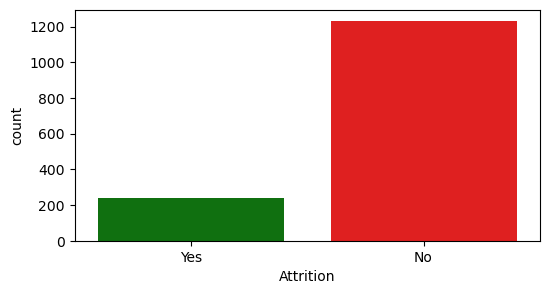

In [166]:
plt.figure(figsize=(6, 3))
sns.countplot(x='Attrition', data=df, hue='Attrition', palette={'Yes': 'green', 'No': 'red'}, legend=False)
plt.show()

In [87]:
numeric_col=list(df.select_dtypes(include=np.number).columns)
categorical_col=list(df.select_dtypes(include=object).columns)
categorical_col

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime']

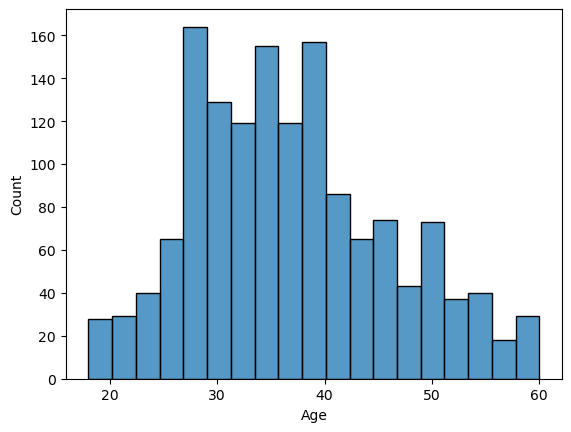

<Figure size 400x300 with 0 Axes>

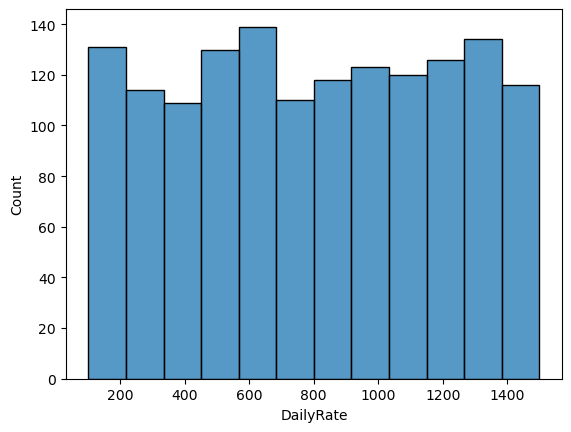

<Figure size 400x300 with 0 Axes>

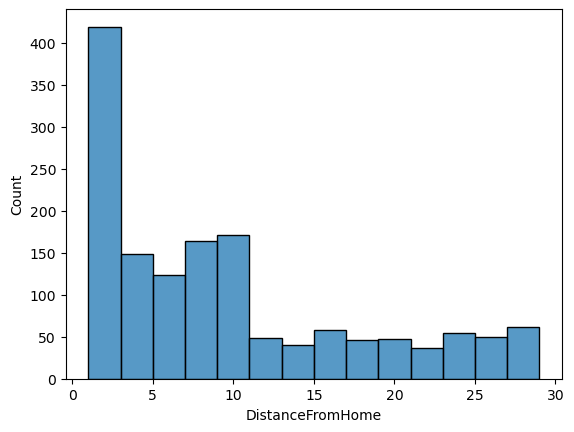

<Figure size 400x300 with 0 Axes>

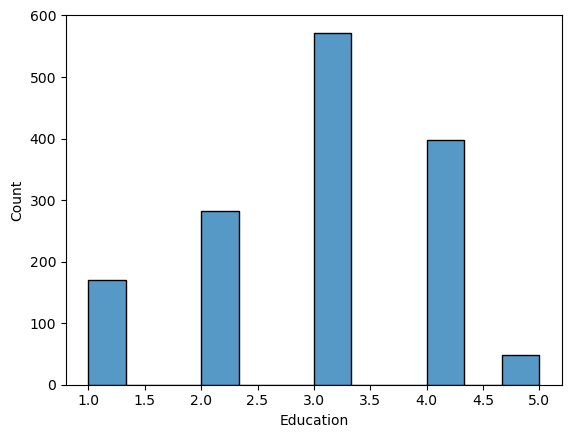

<Figure size 400x300 with 0 Axes>

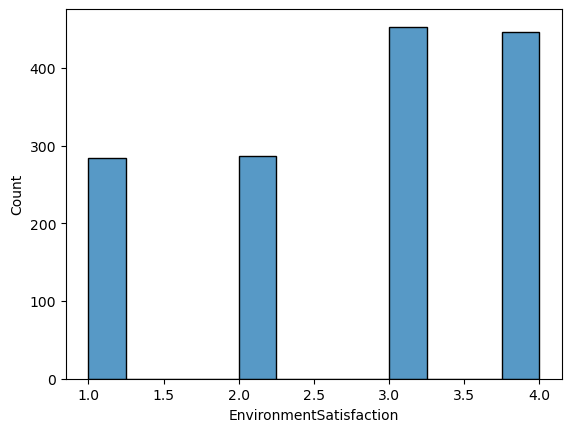

<Figure size 400x300 with 0 Axes>

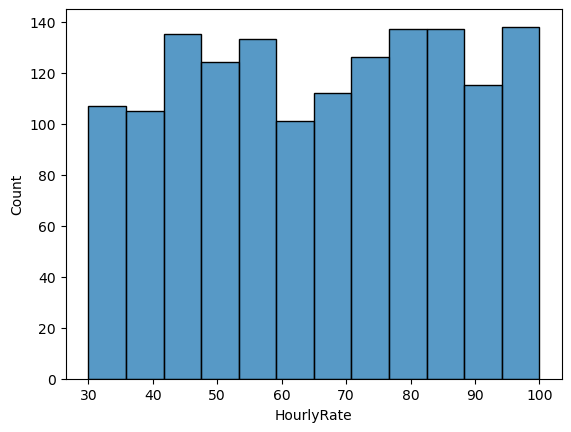

<Figure size 400x300 with 0 Axes>

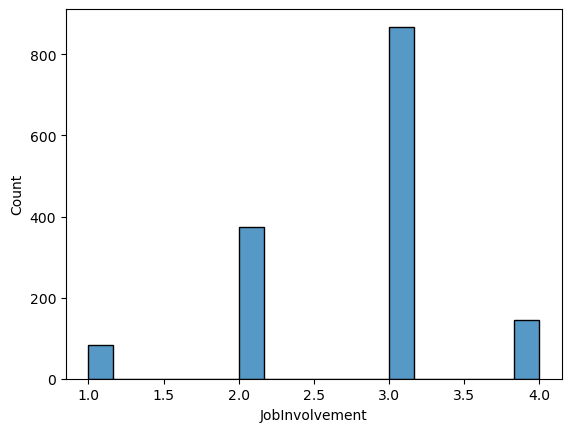

<Figure size 400x300 with 0 Axes>

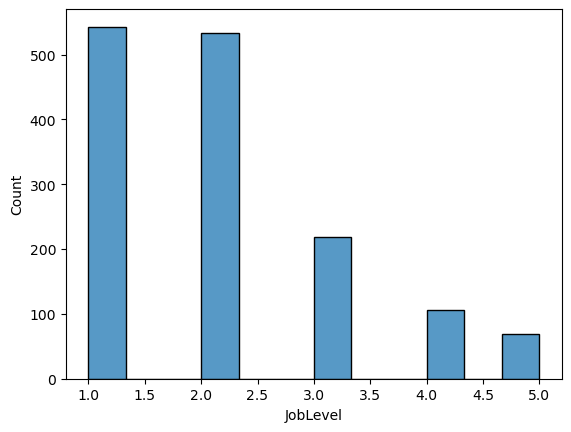

<Figure size 400x300 with 0 Axes>

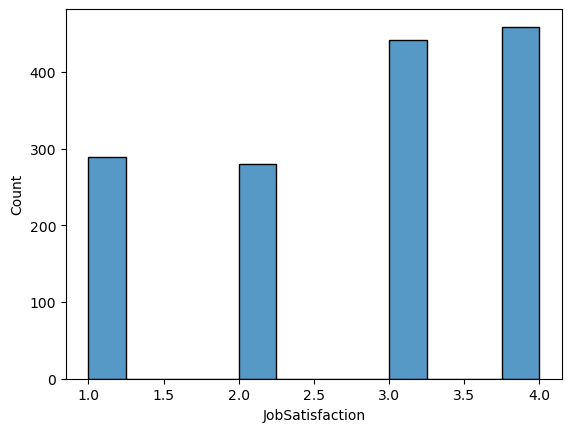

<Figure size 400x300 with 0 Axes>

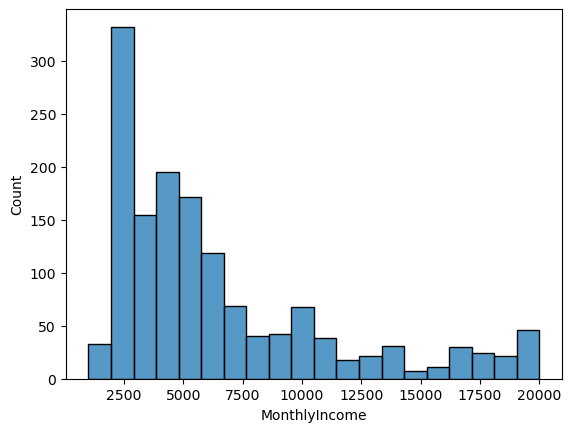

<Figure size 400x300 with 0 Axes>

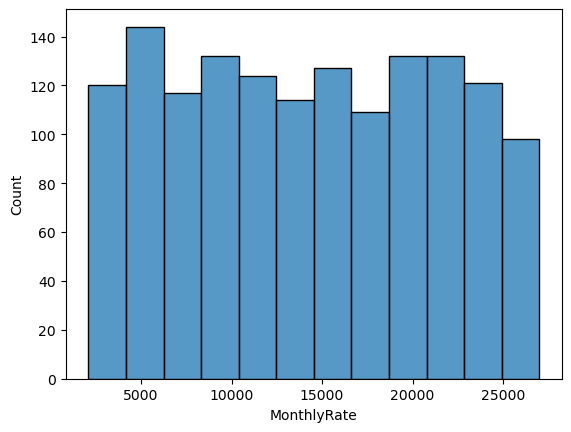

<Figure size 400x300 with 0 Axes>

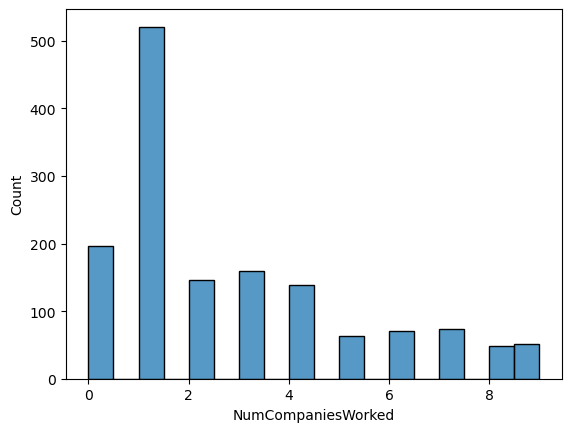

<Figure size 400x300 with 0 Axes>

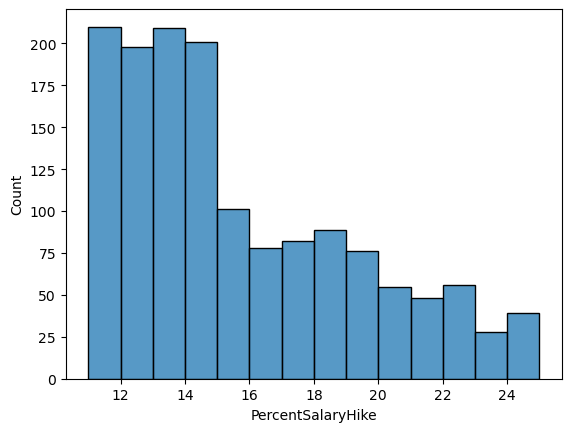

<Figure size 400x300 with 0 Axes>

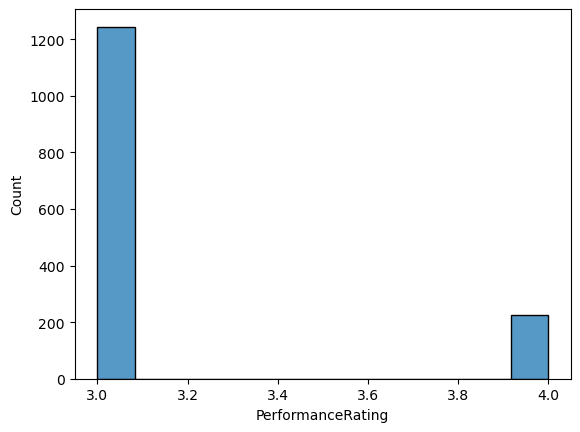

<Figure size 400x300 with 0 Axes>

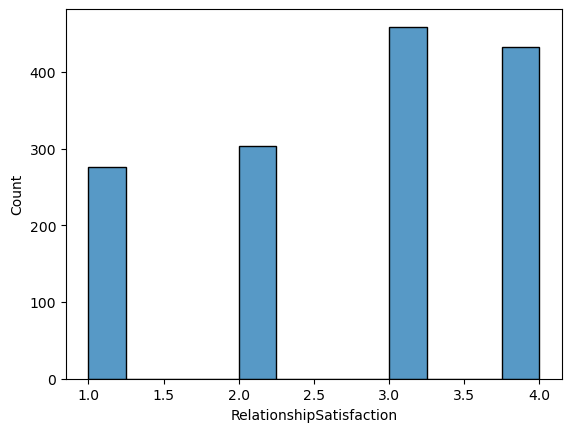

<Figure size 400x300 with 0 Axes>

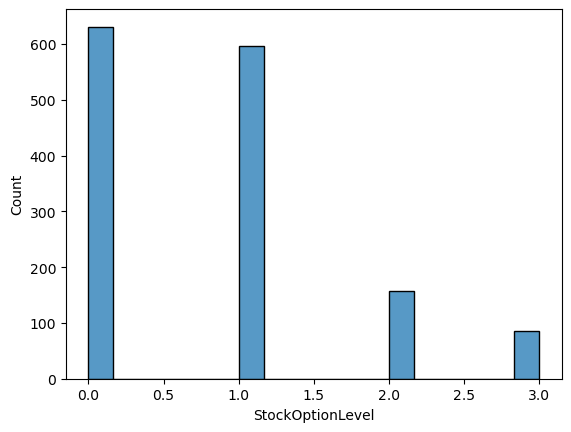

<Figure size 400x300 with 0 Axes>

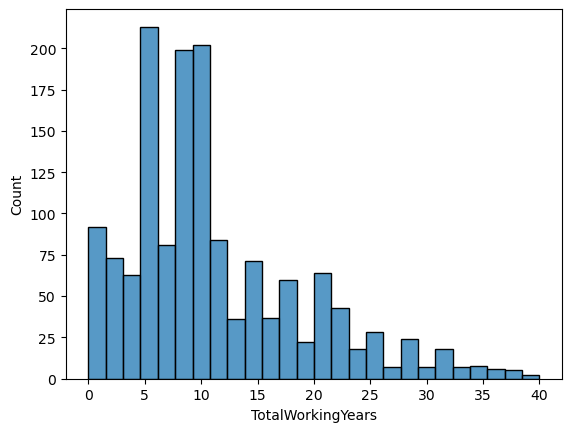

<Figure size 400x300 with 0 Axes>

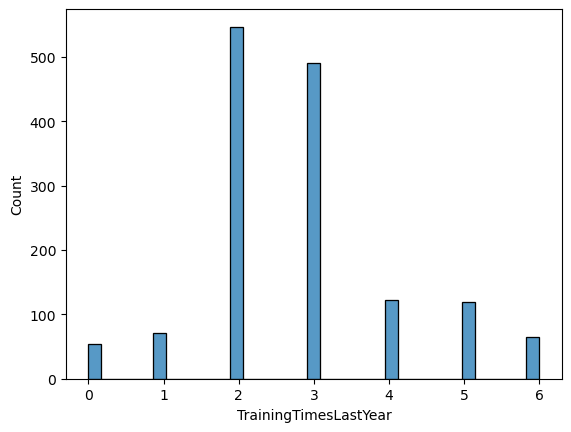

<Figure size 400x300 with 0 Axes>

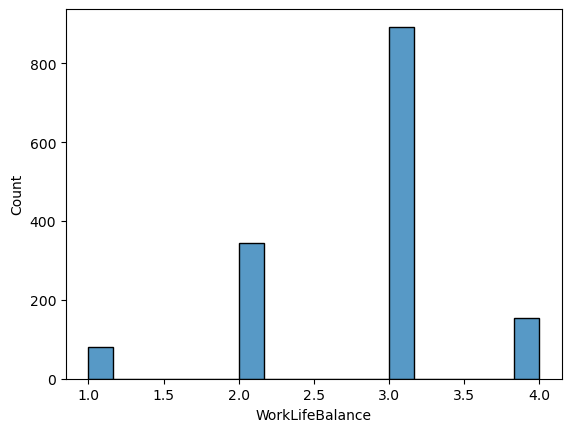

<Figure size 400x300 with 0 Axes>

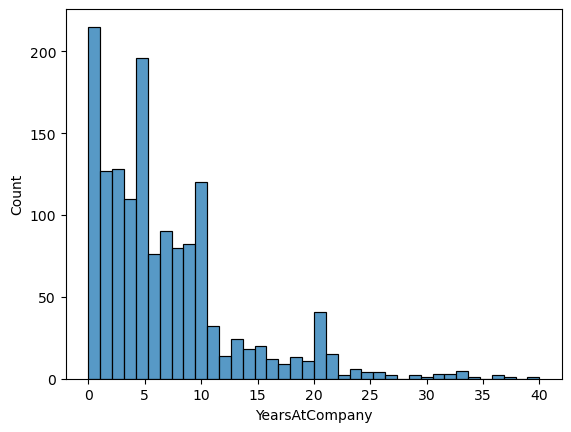

<Figure size 400x300 with 0 Axes>

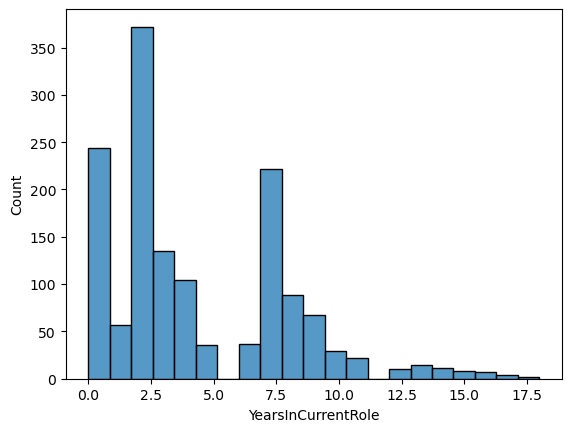

<Figure size 400x300 with 0 Axes>

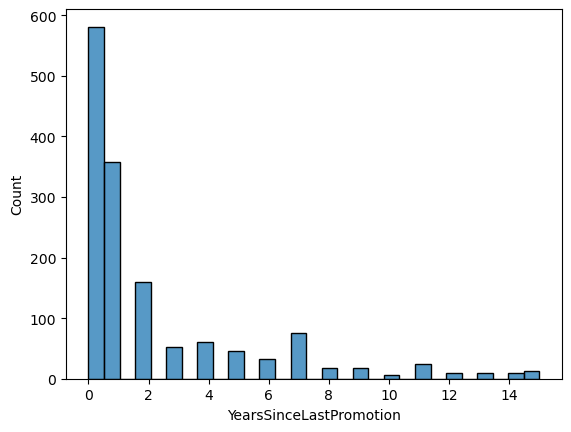

<Figure size 400x300 with 0 Axes>

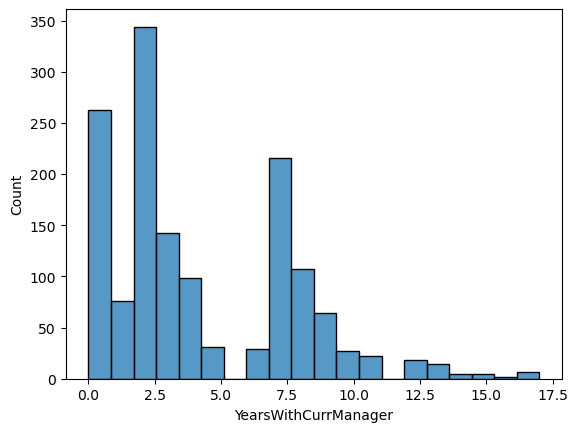

<Figure size 400x300 with 0 Axes>

In [164]:
for col in numeric_col:
    sns.histplot(df[col], kde=False) #kde=False hides the Kernel Density Estimate plot
    plt.xlabel(col)  # Add x-axis label
    plt.ylabel('Count')
    plt.figure(figsize=(4, 3))# Add y-axis label
    plt.show()

In [118]:
df.groupby('Gender')['Attrition'].value_counts()

Gender  Attrition
Female  No           501
        Yes           87
Male    No           732
        Yes          150
Name: count, dtype: int64

<Axes: xlabel='Gender,Attrition'>

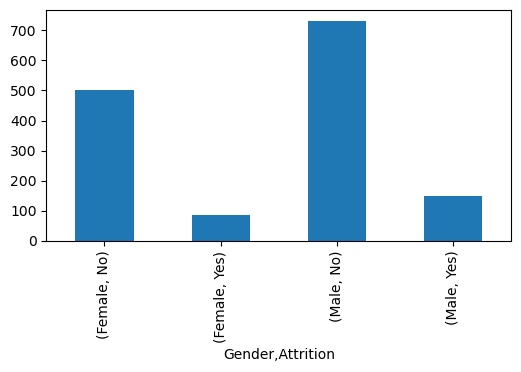

In [160]:
data = df.groupby('Gender')['Attrition'].value_counts()
data.plot(kind='bar', stacked=True, figsize=(6, 3))

In [128]:
df.groupby('Department')['Attrition'].value_counts(normalize=True)
#normalize=True: Returns the proportion of each value rather than the count. 
#This means that the counts are converted into percentages of the total count
#for each department.

Department              Attrition
Human Resources         No           0.809524
                        Yes          0.190476
Research & Development  No           0.861602
                        Yes          0.138398
Sales                   No           0.793722
                        Yes          0.206278
Name: proportion, dtype: float64

In [134]:
df.groupby('JobRole')['Attrition'].value_counts(normalize=True)

JobRole                    Attrition
Healthcare Representative  No           0.931298
                           Yes          0.068702
Human Resources            No           0.769231
                           Yes          0.230769
Laboratory Technician      No           0.760618
                           Yes          0.239382
Manager                    No           0.950980
                           Yes          0.049020
Manufacturing Director     No           0.931034
                           Yes          0.068966
Research Director          No           0.975000
                           Yes          0.025000
Research Scientist         No           0.839041
                           Yes          0.160959
Sales Executive            No           0.825153
                           Yes          0.174847
Sales Representative       No           0.602410
                           Yes          0.397590
Name: proportion, dtype: float64

<Axes: xlabel='JobRole'>

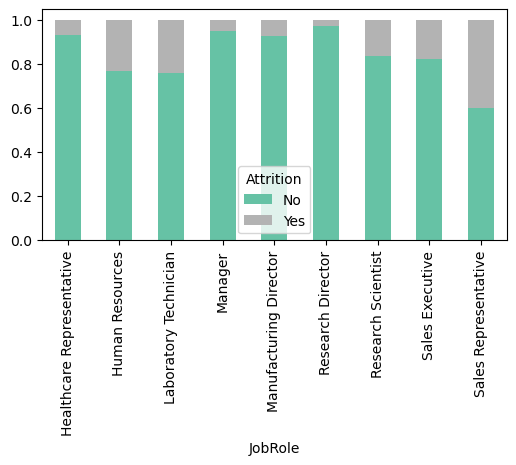

In [144]:
data = df.groupby('JobRole')['Attrition'].value_counts(normalize=True).unstack().fillna(0)

# Plot stacked column bar chart
data.plot(kind='bar', stacked=True, figsize=(6, 3), colormap='Set2')

<Axes: xlabel='Age', ylabel='MonthlyIncome'>

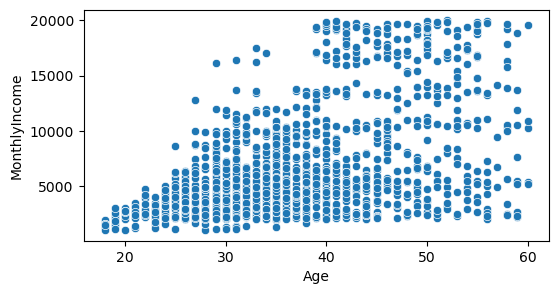

In [158]:
plt.figure(figsize=(6, 3))
sns.scatterplot(data=df,x='Age',y='MonthlyIncome')

In [170]:
df.groupby('JobRole')['MonthlyIncome'].mean()

JobRole
Healthcare Representative     7528.763359
Human Resources               4235.750000
Laboratory Technician         3237.169884
Manager                      17181.676471
Manufacturing Director        7295.137931
Research Director            16033.550000
Research Scientist            3239.972603
Sales Executive               6924.279141
Sales Representative          2626.000000
Name: MonthlyIncome, dtype: float64

In [193]:
x = df.loc[:,df.columns != 'Attrition']
y = df['Attrition']

In [195]:
x

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,...,1,80,0,8,0,1,6,4,0,5
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,...,4,80,1,10,3,3,10,7,1,7
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,...,2,80,0,7,3,3,0,0,0,0
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,3,80,0,8,3,3,8,7,3,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,...,3,80,1,17,3,3,5,2,0,3
1466,39,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,...,1,80,1,9,5,3,7,7,1,7
1467,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,...,2,80,1,6,0,3,6,2,0,3
1468,49,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,...,4,80,0,17,3,2,9,6,0,8


In [197]:
y

0       Yes
1        No
2       Yes
3        No
4        No
       ... 
1465     No
1466     No
1467     No
1468     No
1469     No
Name: Attrition, Length: 1470, dtype: object

MACHINE LEARNING MODEL

In [200]:
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression

In [202]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

array([1, 0, 1, ..., 0, 0, 0])

LABEL ENCODING FOR TARGET ATTRITION

In [211]:
x = pd.get_dummies(x,drop_first = True)
x

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,1,1,2,94,3,2,...,False,False,False,False,False,True,False,False,True,True
1,49,279,8,1,1,2,3,61,2,2,...,False,False,False,False,True,False,False,True,False,False
2,37,1373,2,2,1,4,4,92,2,1,...,True,False,False,False,False,False,False,False,True,True
3,33,1392,3,4,1,5,4,56,3,1,...,False,False,False,False,True,False,False,True,False,True
4,27,591,2,1,1,7,1,40,3,1,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,1,2061,3,41,4,2,...,True,False,False,False,False,False,False,True,False,False
1466,39,613,6,1,1,2062,4,42,2,3,...,False,False,False,False,False,False,False,True,False,False
1467,27,155,4,3,1,2064,2,87,4,2,...,False,False,True,False,False,False,False,True,False,True
1468,49,1023,2,3,1,2065,4,63,2,2,...,False,False,False,False,False,True,False,True,False,False


In [269]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 1,test_size = 0.3,stratify=y)

In [271]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train),columns= x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test),columns= x_train.columns)


In [273]:
x_train.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,-0.977798,0.703245,2.394813,-1.906415,0.0,0.822706,0.257606,1.493827,-2.390644,-0.064735,...,-0.466638,-0.276333,2.998381,-0.228358,-0.495745,-0.525999,-0.230704,1.088445,-0.670295,-0.599427
1,-0.433696,1.102275,-0.151915,1.090073,0.0,0.898886,-1.539526,-0.975408,0.370268,-0.064735,...,-0.466638,-0.276333,-0.333513,-0.228358,-0.495745,1.901144,-0.230704,1.088445,-0.670295,-0.599427
2,0.436868,-1.226659,-1.000824,0.091244,0.0,-0.469043,1.156173,-0.333407,-1.010188,2.672746,...,-0.466638,3.618824,-0.333513,-0.228358,-0.495745,-0.525999,-0.230704,1.088445,-0.670295,-0.599427
3,-0.324875,0.018116,-0.151915,-0.907586,0.0,1.334437,-0.640960,1.296289,1.750724,-0.064735,...,-0.466638,-0.276333,-0.333513,-0.228358,-0.495745,1.901144,-0.230704,1.088445,-0.670295,-0.599427
4,-0.651337,0.434714,-0.758279,-0.907586,0.0,1.541448,0.257606,-0.876639,0.370268,-0.977228,...,-0.466638,-0.276333,-0.333513,-0.228358,2.017168,-0.525999,-0.230704,-0.918742,-0.670295,1.668259


In [275]:
x_test.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,-0.107234,0.339348,-0.879552,1.090073,0.0,-0.098079,0.257606,0.654287,0.370268,-0.977228,...,2.142987,-0.276333,-0.333513,-0.228358,-0.495745,-0.525999,-0.230704,-0.918742,1.491880,-0.599427
1,-0.977798,0.788572,-0.151915,-0.907586,0.0,-1.030457,1.156173,0.012286,0.370268,-0.977228,...,-0.466638,-0.276333,-0.333513,-0.228358,2.017168,-0.525999,-0.230704,-0.918742,1.491880,-0.599427
2,-0.324875,-1.377237,-1.000824,-0.907586,0.0,-0.609811,-0.640960,0.851826,-1.010188,-0.977228,...,-0.466638,-0.276333,-0.333513,-0.228358,2.017168,-0.525999,-0.230704,1.088445,-0.670295,1.668259
3,0.328048,0.238963,-0.394461,-0.907586,0.0,0.882325,0.257606,-1.370486,0.370268,1.760253,...,-0.466638,3.618824,-0.333513,-0.228358,-0.495745,-0.525999,-0.230704,-0.918742,1.491880,1.668259
4,0.980971,-0.694618,-1.000824,-0.907586,0.0,-1.280526,-0.640960,1.296289,0.370268,0.847759,...,-0.466638,-0.276333,-0.333513,-0.228358,-0.495745,1.901144,-0.230704,-0.918742,-0.670295,-0.599427


In [253]:
lr = LogisticRegression()
lr.fit(x_train, y_train.values.ravel())
y_pred = lr.predict(x_test)
y_pred

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [277]:
from sklearn import metrics
metrics.confusion_matrix(y_test,y_pred)

array([[340,  30],
       [ 61,  10]], dtype=int64)

<Axes: >

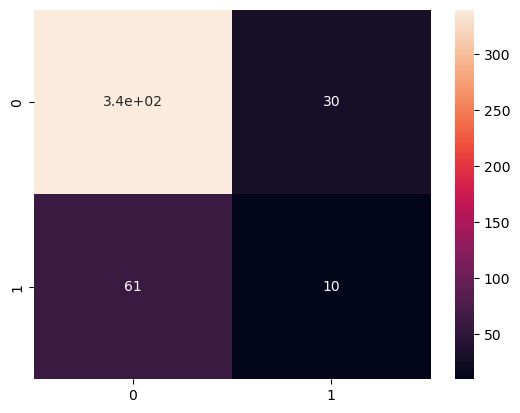

In [279]:
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot = True)

In [265]:
metrics.accuracy_score(y_test,y_pred)

0.8662131519274376

In [281]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       370
           1       0.25      0.14      0.18        71

    accuracy                           0.79       441
   macro avg       0.55      0.53      0.53       441
weighted avg       0.75      0.79      0.77       441

